In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dtreeviz

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score

In [3]:
#データ読み込み
train = pd.read_csv("../dataset/train.csv")
test = pd.read_csv("../dataset/test.csv")
gender_submission = pd.read_csv("../dataset/gender_submission.csv")

#特徴量エンジニアリング
#train
t_train = train["Survived"]
train["FamilySize"] = train["SibSp"] + train["Parch"] 
x_train = train[["Pclass","Sex","Age","FamilySize","Fare","Embarked"]]
x_train["Sex"].replace(["male","female"],[0,1],inplace=True)
# Embarkedをonehot変換
Embarked = pd.get_dummies(x_train["Embarked"])
Embarked.replace([False,True],[0,1],inplace=True)
x_train = x_train.drop(columns=['Embarked'])
x_train = pd.concat([x_train,Embarked],axis = 1)
x_train.fillna(x_train.mean(), inplace=True)
#正規化
x_train = (x_train - x_train.mean()) / x_train.std()
x_train
#test
test["FamilySize"] = test["SibSp"] + test["Parch"] 
x_test = test[["Pclass","Sex","Age","FamilySize","Fare","Embarked"]]
x_test["Sex"].replace(["male","female"],[0,1],inplace=True)
# Embarkedをonehot変換
Embarked = pd.get_dummies(x_test["Embarked"])
Embarked.replace([False,True],[0,1],inplace=True)
x_test = x_test.drop(columns=['Embarked'])
x_test = pd.concat([x_test,Embarked],axis = 1)
x_test.fillna(x_test.mean(), inplace=True)
#正規化
x_test = (x_test - x_test.mean()) / x_test.std()
x_test

C:\Users\logihaal\AppData\Local\Temp\ipykernel_14656\2187756855.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


C:\Users\logihaal\AppData\Local\Temp\ipykernel_14656\2187756855.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
C:\Users\logihaal\AppData\Local\Temp\ipykernel_14656\2187756855.py:11:

,Pclass,Sex,Age,FamilySize,Fare,C,Q,S
0,0.872436,-0.755024,0.334592,-0.552780,-0.497811,-0.567462,2.840354,-1.349059
1,0.872436,1.321292,1.323944,0.105516,-0.512660,-0.567462,-0.351227,0.739484
2,-0.315441,-0.755024,2.511166,-0.552780,-0.464532,-0.567462,2.840354,-1.349059
3,0.872436,-0.755024,-0.259019,-0.552780,-0.482888,-0.567462,-0.351227,0.739484
4,0.872436,1.321292,-0.654760,0.763813,-0.417971,-0.567462,-0.351227,0.739484
...,...,...,...,...,...,...,...,...
413,0.872436,-0.755024,0.000000,-0.552780,-0.493856,-0.567462,-0.351227,0.739484
414,-1.503319,1.321292,0.690758,-0.552780,1.312180,1.758018,-0.351227,-1.349059
415,0.872436,-0.755024,0.651184,-0.552780,-0.508183,-0.567462,-0.351227,0.739484
416,0.872436,-0.755024,0.000000,-0.552780,-0.493856,-0.567462,-0.351227,0.739484


In [4]:
model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=777)
model.fit(x_train, t_train)
t_pred = model.predict(x_train)
rf_score = roc_auc_score(t_train, t_pred)
print(f"ROC-AUC = {rf_score}")

ROC-AUC = 0.8244655354232576


In [5]:
# スタッキング前段に使用するモデル
estimators = [
    ("dt1", DecisionTreeClassifier(max_depth=3, random_state=777)),
    ("dt2", DecisionTreeClassifier(max_depth=4, random_state=777)),
    ("dt3", DecisionTreeClassifier(max_depth=5, random_state=777)),
    ("dt4", DecisionTreeClassifier(max_depth=6, random_state=777)),
]
# スタッキングに含まれるモデル数
n_estimators = len(estimators)
# スタッキング後段に使用するモデル
final_estimator = DecisionTreeClassifier(max_depth=3, random_state=777)
# スタッキングモデルを作成し訓練する
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(x_train, t_train)
# テストデータで評価する
t_pred = clf.predict(x_train)
clf_score = roc_auc_score(t_train, t_pred)

print("ROC-AUC")
print(f"決定木のスタッキング＝{clf_score}, ランダムフォレスト＝{rf_score}")

ROC-AUC
決定木のスタッキング＝0.8323506854568115, ランダムフォレスト＝0.8244655354232576


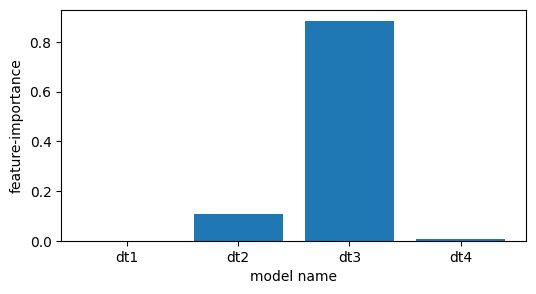

In [6]:
plt.figure(figsize=(6, 3))
plot_index = [i for i in range(n_estimators)]
plt.bar(plot_index, clf.final_estimator_.feature_importances_)
plt.xticks(plot_index, [e[0] for e in estimators])
plt.xlabel("model name")
plt.ylabel("feature-importance")
plt.show()

====
DecisionTreeClassifier(max_depth=3, random_state=777)
0.8057233247052056
====
KNeighborsClassifier()
0.8471862716901543
====
DecisionTreeClassifier(max_depth=5, random_state=777)
0.8205109768957914
====
LinearSVC(max_iter=500)
0.7811091937494007
====
LinearSVC(max_iter=500)
0.7811091937494007


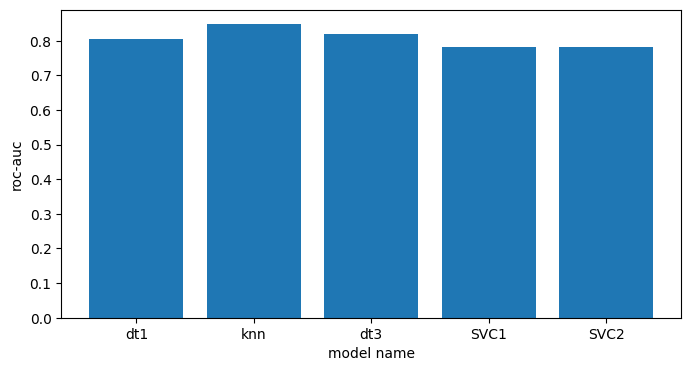

In [15]:
# スタッキング前段の木の精度を計測する
scores = []
for clf_estim in clf.estimators_:
    print("====")
    t_pred = clf_estim.predict(x_train)
    scr = roc_auc_score(t_train, t_pred)
    scores.append(scr)
    print(clf_estim)
    print(scr)

n_estimators = len(estimators)
plot_index = [i for i in range(n_estimators)]

# グラフ作成
plt.figure(figsize=(8, 4))
plt.bar(plot_index, scores)
plt.xticks(plot_index, [e[0] for e in estimators])
plt.xlabel("model name")
plt.ylabel("roc-auc")
plt.show()


In [13]:
#複数の木でスタッキングしてみる
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
#スタッキング前段に使用するモデル
estimators = [
    ("dt1", DecisionTreeClassifier(max_depth=3, random_state=777)),
    ("knn", KNeighborsClassifier()),
    ("dt3", DecisionTreeClassifier(max_depth=5, random_state=777)),
    ("SVC1", LinearSVC(max_iter=500)),
    ("SVC2", LinearSVC(max_iter=500)),
    
]
# スタッキングに含まれるモデル数
n_estimators = len(estimators)
# スタッキング後段に使用するモデル
final_estimator = DecisionTreeClassifier(max_depth=3, random_state=777)
# スタッキングモデルを作成し訓練する
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(x_train, t_train)
# テストデータで評価する
t_pred = clf.predict(x_train)
clf_score = roc_auc_score(t_train, t_pred)

print("ROC-AUC")
print(f"決定木のスタッキング＝{clf_score}, ランダムフォレスト＝{rf_score}")

ROC-AUC
決定木のスタッキング＝0.8496548748921484, ランダムフォレスト＝0.8244655354232576


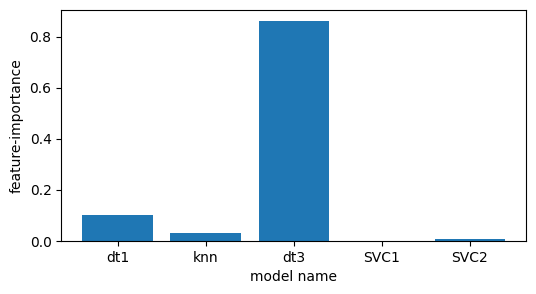

In [14]:
plt.figure(figsize=(6, 3))
plot_index = [i for i in range(n_estimators)]
plt.bar(plot_index, clf.final_estimator_.feature_importances_)
plt.xticks(plot_index, [e[0] for e in estimators])
plt.xlabel("model name")
plt.ylabel("feature-importance")
plt.show()

====
DecisionTreeClassifier(max_depth=3, random_state=777)
0.8057233247052056
====
KNeighborsClassifier()
0.8471862716901543
====
DecisionTreeClassifier(max_depth=5, random_state=777)
0.8205109768957914
====
LinearSVC(max_iter=500)
0.7811091937494007
====
LinearSVC(max_iter=500)
0.7811091937494007


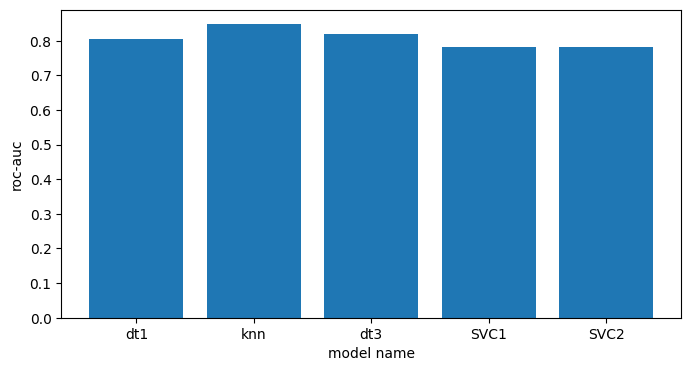

In [16]:
# スタッキング前段の木の精度を計測する
scores = []
for clf_estim in clf.estimators_:
    print("====")
    t_pred = clf_estim.predict(x_train)
    scr = roc_auc_score(t_train, t_pred)
    scores.append(scr)
    print(clf_estim)
    print(scr)

n_estimators = len(estimators)
plot_index = [i for i in range(n_estimators)]

# グラフ作成
plt.figure(figsize=(8, 4))
plt.bar(plot_index, scores)
plt.xticks(plot_index, [e[0] for e in estimators])
plt.xlabel("model name")
plt.ylabel("roc-auc")
plt.show()


In [17]:
t_test = clf.predict(x_test)

In [19]:
x_test["Survived"] = t_test
t_output = x_test["Survived"]
t_output.index = t_output.index + 892
t_output.index.rename('PassengerId', inplace=True)
# DataFrameをCSVに出力
t_output.to_csv("output_Stacking.csv")